## Set up

How to use XGBoost in RecSys
* Run your best algorithm and select a number of recommendations higher than the target cutoff, for example if you have to compute MAP@10, get 20 recommendations
* Build a dataframe whose samples are the user-item recommendations
* Add for each interaction some content features: item features, user features
* Add for each interaction some features derived by other algorithms: CBF prediction, hybrid prediction
* Add for each interaction other miscellaneous information: profile length, item popularity ..

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import polars as pl
import scipy.sparse as sps
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from xgboost import XGBRanker

from Data_manager.competition import load, load_raw
from Recommenders.BaseRecommender import BaseRecommender
from Recommenders.Similarity.Compute_Similarity import Compute_Similarity
from Recommenders.Hybrid import UserWideHybridRecommender, ScoresMultipleHybridRecommender

In [3]:
NUMBER_FOLDS = 10
CUTOFF = 10

In [4]:
MODELS_DIR = Path() / "models" / "train" / "map"
MODELS_DIR.exists()

True

In [5]:
TEST_ID_PATH = Path() / "Data_manager_split_datasets" / "competition" / "data_target_users_test.csv"
test_df = pd.read_csv(TEST_ID_PATH)
test_df

,user_id
0,0
1,1
2,2
3,3
4,4
...,...
34226,35729
34227,35730
34228,35731
34229,35734


In [6]:
SUBMISSION_PATH = Path("submission.csv")

In [7]:
icm_df, urm_df = load_raw()
number_users = urm_df["user_id"].nunique()
number_items = icm_df["item_id"].nunique()
print(number_users, number_items)

35736 38121


In [8]:
icm_matrix, urm_all, urm_train, urm_validation, urm_test = load()
ranker_urm = urm_validation + urm_test

In [9]:
def encode_user_dicts(user_dicts: list[dict]) -> dict:
    return  {
        user_dict["UserID"]: user_dict["ItemID"][0]
        for user_dict in user_dicts
    }

In [10]:
def item_to_list() -> pl.Expr:
    return pl.col("ItemID").implode()

In [11]:
def decode_predictions(input_df: pd.DataFrame, drop_ids: bool = False) -> dict[int, list]:
    output_df = input_df[["UserID", "ItemID"]].copy()
    if drop_ids:
        input_df = input_df.drop(columns=["UserID", "ItemID"])
    output_df["Score"] = XGB_model.predict(input_df)

    output_dicts = (
        pl.from_pandas(output_df)
        .group_by("UserID", "ItemID")
        .agg(pl.mean("Score"))
        .sort("UserID", "Score", descending=True)
        .group_by("UserID")
        .head(10)
        .group_by("UserID")
        .agg(item_to_list())
        .to_dicts()
    )
    return encode_user_dicts(output_dicts)

## Data processing

### Candidate generation

#### Training

In [37]:
USER_WIDE_HYBRID_BEGIN = 30
MODELS_TO_USE = (
    60,
    61,
    62,
    63,
)

In [38]:
NUMBER_GROUPS_USER_WIDE_HYBRID = 10
MULTIPLE_SCORE_HYBRID_WEIGHTS = {
    50: 0.253770701546336,
    51: 0.10324855050317669,
}


def build_user_wide_hybrid(urm: sps.csr_matrix, models: dict[str, BaseRecommender]):
    profile_lengths = np.ediff1d(urm.indptr)
    sorted_users = np.argsort(profile_lengths)
    block_size = len(sorted_users) // NUMBER_GROUPS_USER_WIDE_HYBRID
    group_users = {}
    for group in range(NUMBER_GROUPS_USER_WIDE_HYBRID + 1):
        group_users[group] = sorted_users[group * block_size : (group + 1) * block_size]
    group_recommenders = {
        group: models.pop(str(USER_WIDE_HYBRID_BEGIN + group)) for group in range(NUMBER_GROUPS_USER_WIDE_HYBRID + 1)
    }
    return UserWideHybridRecommender(urm, group_users, group_recommenders)

def build_score_hybrid(urm: sps.csr_matrix, models: dict[str, BaseRecommender]):
    recommenders = [models.pop(str(index)) for index in MULTIPLE_SCORE_HYBRID_WEIGHTS.keys()]
    weights = list(MULTIPLE_SCORE_HYBRID_WEIGHTS.values())
    return ScoresMultipleHybridRecommender(urm, recommenders, weights)

In [39]:
fold_training_dataframes: dict[int, pd.DataFrame] = {}
for i, (train_indices, val_indices) in tqdm(
    enumerate(KFold(NUMBER_FOLDS, shuffle=True, random_state=42).split(urm_df)),
    total=NUMBER_FOLDS,
    desc="Fold",
):
    fold_urm_train_df = urm_df.iloc[train_indices]
    fold_urm_train  = sps.csr_matrix(
        (fold_urm_train_df.data, (fold_urm_train_df.user_id, fold_urm_train_df.item_id)),
        shape=(number_users, number_items),
    )

    fold_models_dir = MODELS_DIR / str(i)
    models: dict[str, BaseRecommender] = {
        path.stem: pickle.load(path.open("rb"))
        for path in fold_models_dir.glob("*.pkl")
    }
    if "user_wide_hybrid" not in models:
        fold_user_wide_hybrid = build_user_wide_hybrid(fold_urm_train, models)
    # if "score_hybrid" not in models:
    #     fold_score_hybrid = build_score_hybrid(fold_urm_train, models)

    models = {str(index): models[str(index)] for index in MODELS_TO_USE}
    if "user_wide_hybrid" not in models:
        models["user_wide_hybrid"] = fold_user_wide_hybrid
    # if "score_hybrid" not in models:
    #     models["score_hybrid"] = fold_score_hybrid

    training_dataframe = pd.DataFrame(index=range(0, number_users), columns=["ItemID"])
    training_dataframe.index.name = "UserID"

    recommendations_list = []
    recommenders_list = []
    rank_list = []
    for user_id in tqdm(range(number_users), desc="User (candidate)"):
        user_recommendations = []
        user_recommenders = []
        user_rankings = []
        for name, recommender in models.items():
            user_recommendations.extend(
                recommender.recommend(
                    user_id,
                    cutoff=CUTOFF,
                    remove_seen_flag=True,
                )
            )
            user_recommenders.extend([name] * CUTOFF)
            user_rankings.extend(list(range(CUTOFF)))
        recommendations_list.append(user_recommendations)
        recommenders_list.append(user_recommenders)
        rank_list.append(user_rankings)

    training_dataframe["ItemID"] = recommendations_list
    training_dataframe["Recommender"] = recommenders_list
    training_dataframe["Ranking"] = rank_list

    exploded_recommender = training_dataframe["Recommender"].explode()
    exploded_ranking = training_dataframe["Ranking"].explode()
    training_dataframe = training_dataframe.explode("ItemID")
    training_dataframe["Recommender"] = exploded_recommender
    training_dataframe["Ranking"] = exploded_ranking.astype("int")

    recommender_agreement = (
        training_dataframe.reset_index()[["UserID", "ItemID"]]
        .groupby(["UserID", "ItemID"])
        .value_counts()
    )
    training_dataframe["recommender_agreement"] = recommender_agreement.loc[
        list(zip(training_dataframe.index, training_dataframe["ItemID"]))
    ].to_numpy()

    fold_urm_val_df = urm_df.iloc[val_indices]
    fold_urm_val  = sps.csr_matrix(
        (fold_urm_val_df.data, (fold_urm_val_df.user_id, fold_urm_val_df.item_id)),
        shape=(number_users, number_items),
    )
    fold_urm_coo = sps.coo_matrix(fold_urm_val)
    correct_recommendations = pd.DataFrame(
        {"UserID": fold_urm_coo.row, "ItemID": fold_urm_coo.col}
    )
    training_dataframe = training_dataframe.merge(
        correct_recommendations,
        on=["UserID", "ItemID"],
        how="left",
        indicator="Exist",
    )
    training_dataframe["Label"] = training_dataframe["Exist"] == "both"
    training_dataframe = training_dataframe.drop(columns=["Exist"])

    training_dataframe = training_dataframe.set_index("UserID")
    for user_id in tqdm(training_dataframe.index.unique(), desc="User (score)"):
        for rec_label, rec_instance in models.items():
            item_list = training_dataframe.loc[user_id, "ItemID"].to_list()

            all_item_scores = rec_instance._compute_item_score(
                [user_id], items_to_compute=item_list
            )

            training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list]

    training_dataframe = training_dataframe.reset_index()
    training_dataframe = training_dataframe.rename(columns={"index": "UserID"})

    training_dataframe["fold"] = i
    fold_training_dataframes[i] = training_dataframe

Fold:   0%|          | 0/10 [00:00<?, ?it/s]

/home/tomaz/git/Politecnico/Subjects/recommender-systems/recsys-competition/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ElasticNet from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


User (candidate):   0%|          | 0/35736 [00:00<?, ?it/s]

User (score):   0%|          | 0/35736 [00:00<?, ?it/s]

/home/tomaz/git/Politecnico/Subjects/recommender-systems/recsys-competition/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ElasticNet from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


User (candidate):   0%|          | 0/35736 [00:00<?, ?it/s]

User (score):   0%|          | 0/35736 [00:00<?, ?it/s]

/home/tomaz/git/Politecnico/Subjects/recommender-systems/recsys-competition/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ElasticNet from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


User (candidate):   0%|          | 0/35736 [00:00<?, ?it/s]

User (score):   0%|          | 0/35736 [00:00<?, ?it/s]

/home/tomaz/git/Politecnico/Subjects/recommender-systems/recsys-competition/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ElasticNet from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


User (candidate):   0%|          | 0/35736 [00:00<?, ?it/s]

User (score):   0%|          | 0/35736 [00:00<?, ?it/s]

/home/tomaz/git/Politecnico/Subjects/recommender-systems/recsys-competition/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ElasticNet from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


User (candidate):   0%|          | 0/35736 [00:00<?, ?it/s]

User (score):   0%|          | 0/35736 [00:00<?, ?it/s]

/home/tomaz/git/Politecnico/Subjects/recommender-systems/recsys-competition/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ElasticNet from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


User (candidate):   0%|          | 0/35736 [00:00<?, ?it/s]

User (score):   0%|          | 0/35736 [00:00<?, ?it/s]

/home/tomaz/git/Politecnico/Subjects/recommender-systems/recsys-competition/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ElasticNet from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


User (candidate):   0%|          | 0/35736 [00:00<?, ?it/s]

User (score):   0%|          | 0/35736 [00:00<?, ?it/s]

/home/tomaz/git/Politecnico/Subjects/recommender-systems/recsys-competition/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ElasticNet from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


User (candidate):   0%|          | 0/35736 [00:00<?, ?it/s]

User (score):   0%|          | 0/35736 [00:00<?, ?it/s]

/home/tomaz/git/Politecnico/Subjects/recommender-systems/recsys-competition/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ElasticNet from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


User (candidate):   0%|          | 0/35736 [00:00<?, ?it/s]

User (score):   0%|          | 0/35736 [00:00<?, ?it/s]

/home/tomaz/git/Politecnico/Subjects/recommender-systems/recsys-competition/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ElasticNet from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


User (candidate):   0%|          | 0/35736 [00:00<?, ?it/s]

User (score):   0%|          | 0/35736 [00:00<?, ?it/s]

In [40]:
training_dataframe = pd.concat(fold_training_dataframes.values())
training_dataframe

,UserID,ItemID,Recommender,Ranking,recommender_agreement,Label,60,61,62,63,user_wide_hybrid,fold
0,0,7703,60,0,4,False,0.268031,0.401745,2.693894,0.085774,0.272271,0
1,0,7547,60,1,4,False,0.258316,0.352410,2.404292,0.066998,0.265295,0
2,0,6822,60,2,3,True,0.237978,0.143136,0.850208,0.182649,0.221734,0
3,0,572,60,3,5,False,0.234505,0.300062,1.903718,0.160482,0.222038,0
4,0,3077,60,4,4,True,0.234102,0.241273,1.361896,0.182695,0.232855,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1786795,35735,37445,user_wide_hybrid,5,5,False,0.343499,0.630422,4.550226,0.199559,0.353038,9
1786796,35735,37507,user_wide_hybrid,6,2,False,0.313335,0.395291,1.350077,0.171390,0.333600,9
1786797,35735,36775,user_wide_hybrid,7,5,False,0.326151,0.581158,3.998512,0.191833,0.327440,9
1786798,35735,34998,user_wide_hybrid,8,2,False,0.326401,0.430699,2.925698,0.127431,0.326283,9


#### Submission

In [30]:
submit_models_dir = Path() / "models" / "all" / "0"
models: dict[str, BaseRecommender] = {
    path.stem: pickle.load(path.open("rb"))
    for path in submit_models_dir.glob("*.pkl")
}

submission_dataframe = pd.DataFrame(index=range(0, number_users), columns=["ItemID"])
submission_dataframe.index.name = "UserID"

recommendations_list = []
recommenders_list = []
rank_list = []
for user_id in tqdm(range(number_users), desc="User (candidate)"):
    user_recommendations = []
    user_recommenders = []
    user_rankings = []
    for name, recommender in models.items():
        user_recommendations.extend(
            recommender.recommend(
                user_id,
                cutoff=CUTOFF,
                remove_seen_flag=True,
            )
        )
        user_recommenders.extend([name] * CUTOFF)
        user_rankings.extend(list(range(CUTOFF)))
    recommendations_list.append(user_recommendations)
    recommenders_list.append(user_recommenders)
    rank_list.append(user_rankings)

submission_dataframe["ItemID"] = recommendations_list
submission_dataframe["Recommender"] = recommenders_list
submission_dataframe["Ranking"] = rank_list

exploded_recommender = submission_dataframe["Recommender"].explode()
exploded_ranking = submission_dataframe["Ranking"].explode()
submission_dataframe = submission_dataframe.explode("ItemID")
submission_dataframe["Recommender"] = exploded_recommender
submission_dataframe["Ranking"] = exploded_ranking.astype("int")

recommender_agreement = (
    submission_dataframe.reset_index()[["UserID", "ItemID"]]
    .groupby(["UserID", "ItemID"])
    .value_counts()
)
submission_dataframe["recommender_agreement"] = recommender_agreement.loc[
    list(zip(submission_dataframe.index, submission_dataframe["ItemID"]))
].to_numpy()


for user_id in tqdm(submission_dataframe.index.unique(), desc="User (score)"):
    for rec_label, rec_instance in models.items():
        item_list = submission_dataframe.loc[user_id, "ItemID"].to_list()

        all_item_scores = rec_instance._compute_item_score(
            [user_id], items_to_compute=item_list
        )

        submission_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list]

submission_dataframe = submission_dataframe.reset_index()
submission_dataframe = submission_dataframe.rename(columns={"index": "UserID"})
submission_dataframe

User (candidate):   0%|          | 0/35736 [00:00<?, ?it/s]

User (score):   0%|          | 0/35736 [00:00<?, ?it/s]

,UserID,ItemID,Recommender,Ranking,recommender_agreement,23,21,22,20,user_wide_hybrid
0,0,572,23,0,4,3.708066,0.364245,0.184505,0.906074,0.288273
1,0,14888,23,1,4,3.389925,0.282408,0.327246,1.195710,0.312018
2,0,452,23,2,1,3.183915,0.180780,0.072435,0.279713,0.242547
3,0,9911,23,3,2,2.940626,0.226980,0.315740,1.171455,0.176901
4,0,14931,23,4,1,2.921493,0.238371,0.189480,0.695994,0.246573
...,...,...,...,...,...,...,...,...,...,...
1786795,35735,36775,user_wide_hybrid,5,3,8.471791,0.328802,0.358924,2.157352,0.664134
1786796,35735,37660,user_wide_hybrid,6,3,7.323517,0.347563,0.192113,1.368214,0.588393
1786797,35735,36920,user_wide_hybrid,7,3,7.601600,0.342447,0.263019,1.772518,0.581799
1786798,35735,37017,user_wide_hybrid,8,2,4.652850,0.303232,0.303558,2.394336,0.573921


In [31]:
training_dataframe = submission_dataframe
training_dataframe

,UserID,ItemID,Recommender,Ranking,recommender_agreement,23,21,22,20,user_wide_hybrid
0,0,572,23,0,4,3.708066,0.364245,0.184505,0.906074,0.288273
1,0,14888,23,1,4,3.389925,0.282408,0.327246,1.195710,0.312018
2,0,452,23,2,1,3.183915,0.180780,0.072435,0.279713,0.242547
3,0,9911,23,3,2,2.940626,0.226980,0.315740,1.171455,0.176901
4,0,14931,23,4,1,2.921493,0.238371,0.189480,0.695994,0.246573
...,...,...,...,...,...,...,...,...,...,...
1786795,35735,36775,user_wide_hybrid,5,3,8.471791,0.328802,0.358924,2.157352,0.664134
1786796,35735,37660,user_wide_hybrid,6,3,7.323517,0.347563,0.192113,1.368214,0.588393
1786797,35735,36920,user_wide_hybrid,7,3,7.601600,0.342447,0.263019,1.772518,0.581799
1786798,35735,37017,user_wide_hybrid,8,2,4.652850,0.303232,0.303558,2.394336,0.573921


### Item features

#### Item popularity

In [41]:
item_popularity = np.ediff1d(sps.csc_matrix(urm_all).indptr)

In [42]:
training_dataframe["item_popularity"] = item_popularity[
    training_dataframe["ItemID"].to_numpy().astype(int)
]
training_dataframe

,UserID,ItemID,Recommender,Ranking,recommender_agreement,Label,60,61,62,63,user_wide_hybrid,fold,item_popularity
0,0,7703,60,0,4,False,0.268031,0.401745,2.693894,0.085774,0.272271,0,79
1,0,7547,60,1,4,False,0.258316,0.352410,2.404292,0.066998,0.265295,0,43
2,0,6822,60,2,3,True,0.237978,0.143136,0.850208,0.182649,0.221734,0,203
3,0,572,60,3,5,False,0.234505,0.300062,1.903718,0.160482,0.222038,0,93
4,0,3077,60,4,4,True,0.234102,0.241273,1.361896,0.182695,0.232855,0,259
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1786795,35735,37445,user_wide_hybrid,5,5,False,0.343499,0.630422,4.550226,0.199559,0.353038,9,27
1786796,35735,37507,user_wide_hybrid,6,2,False,0.313335,0.395291,1.350077,0.171390,0.333600,9,108
1786797,35735,36775,user_wide_hybrid,7,5,False,0.326151,0.581158,3.998512,0.191833,0.327440,9,88
1786798,35735,34998,user_wide_hybrid,8,2,False,0.326401,0.430699,2.925698,0.127431,0.326283,9,57


#### Distance to closest items

In [43]:
item_similarity = Compute_Similarity(icm_matrix.T).compute_similarity()
item_similarity

Similarity column 38121 (100.0%), 885.66 column/sec. Elapsed time 43.04 sec


<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 3812100 stored elements and shape (38121, 38121)>

In [44]:
mean_item_similarity_dict = {i: row.mean() for i, row in enumerate(item_similarity)}
mean_item_similarity: pd.DataFrame = pd.Series(mean_item_similarity_dict).to_frame(name="item_similarity")
mean_item_similarity

,item_similarity
0,0.000046
1,0.000309
2,0.000140
3,0.000105
4,0.000015
...,...
38116,0.000397
38117,0.007546
38118,0.005463
38119,0.000602


In [45]:
training_dataframe = training_dataframe.join(mean_item_similarity, on="ItemID")
training_dataframe

,UserID,ItemID,Recommender,Ranking,recommender_agreement,Label,60,61,62,63,user_wide_hybrid,fold,item_popularity,item_similarity
0,0,7703,60,0,4,False,0.268031,0.401745,2.693894,0.085774,0.272271,0,79,0.000730
1,0,7547,60,1,4,False,0.258316,0.352410,2.404292,0.066998,0.265295,0,43,0.000170
2,0,6822,60,2,3,True,0.237978,0.143136,0.850208,0.182649,0.221734,0,203,0.000112
3,0,572,60,3,5,False,0.234505,0.300062,1.903718,0.160482,0.222038,0,93,0.000246
4,0,3077,60,4,4,True,0.234102,0.241273,1.361896,0.182695,0.232855,0,259,0.001331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1786795,35735,37445,user_wide_hybrid,5,5,False,0.343499,0.630422,4.550226,0.199559,0.353038,9,27,0.000132
1786796,35735,37507,user_wide_hybrid,6,2,False,0.313335,0.395291,1.350077,0.171390,0.333600,9,108,0.002226
1786797,35735,36775,user_wide_hybrid,7,5,False,0.326151,0.581158,3.998512,0.191833,0.327440,9,88,0.003954
1786798,35735,34998,user_wide_hybrid,8,2,False,0.326401,0.430699,2.925698,0.127431,0.326283,9,57,0.000664


### User features

#### User popularity

In [46]:
user_popularity = np.ediff1d(sps.csr_matrix(urm_all).indptr)

In [47]:
training_dataframe["user_profile_len"] = user_popularity[
    training_dataframe["UserID"].to_numpy().astype(int)
]
training_dataframe

,UserID,ItemID,Recommender,Ranking,recommender_agreement,Label,60,61,62,63,user_wide_hybrid,fold,item_popularity,item_similarity,user_profile_len
0,0,7703,60,0,4,False,0.268031,0.401745,2.693894,0.085774,0.272271,0,79,0.000730,114
1,0,7547,60,1,4,False,0.258316,0.352410,2.404292,0.066998,0.265295,0,43,0.000170,114
2,0,6822,60,2,3,True,0.237978,0.143136,0.850208,0.182649,0.221734,0,203,0.000112,114
3,0,572,60,3,5,False,0.234505,0.300062,1.903718,0.160482,0.222038,0,93,0.000246,114
4,0,3077,60,4,4,True,0.234102,0.241273,1.361896,0.182695,0.232855,0,259,0.001331,114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1786795,35735,37445,user_wide_hybrid,5,5,False,0.343499,0.630422,4.550226,0.199559,0.353038,9,27,0.000132,37
1786796,35735,37507,user_wide_hybrid,6,2,False,0.313335,0.395291,1.350077,0.171390,0.333600,9,108,0.002226,37
1786797,35735,36775,user_wide_hybrid,7,5,False,0.326151,0.581158,3.998512,0.191833,0.327440,9,88,0.003954,37
1786798,35735,34998,user_wide_hybrid,8,2,False,0.326401,0.430699,2.925698,0.127431,0.326283,9,57,0.000664,37


#### User popularity bias

Measure of how much popularity influences the user

In [48]:
item_popularity_ranking = item_popularity.argsort()[::-1]
item_popularity_ranking

array([11146, 25392,  4601, ...,  8491, 21675,  8152])

In [49]:
item_id_df = urm_df[["user_id", "item_id"]]
item_id_df

,user_id,item_id
0,0,0
1,0,2
2,0,120
3,0,128
4,0,211
...,...,...
1764602,35735,37802
1764603,35735,37803
1764604,35735,37805
1764605,35735,38000


In [50]:
TOP_POPULAR_THRESHOLDS = (10, 100, 1000)

In [51]:
for k in TOP_POPULAR_THRESHOLDS:
    top_k_popular = item_popularity_ranking[:k]
    item_id_df.loc[item_id_df["item_id"].isin(top_k_popular), f"top_{k}"] = 1
item_id_df = item_id_df.fillna(0)
item_id_df

,user_id,item_id,top_10,top_100,top_1000
0,0,0,0.0,0.0,0.0
1,0,2,0.0,0.0,0.0
2,0,120,0.0,0.0,0.0
3,0,128,0.0,0.0,0.0
4,0,211,0.0,0.0,1.0
...,...,...,...,...,...
1764602,35735,37802,0.0,0.0,0.0
1764603,35735,37803,0.0,0.0,0.0
1764604,35735,37805,0.0,0.0,0.0
1764605,35735,38000,0.0,0.0,0.0


In [52]:
user_top_k_df = item_id_df.groupby("user_id").aggregate({f"top_{k}": "sum" for k in TOP_POPULAR_THRESHOLDS})
user_top_k_df

,top_10,top_100,top_1000
user_id,,,
0,0.0,1.0,7.0
1,2.0,3.0,10.0
2,0.0,0.0,0.0
3,1.0,4.0,11.0
4,0.0,3.0,29.0
...,...,...,...
35731,0.0,0.0,0.0
35732,0.0,0.0,1.0
35733,0.0,0.0,0.0


In [53]:
training_dataframe = training_dataframe.join(user_top_k_df, on="UserID")
training_dataframe

,UserID,ItemID,Recommender,Ranking,recommender_agreement,Label,60,61,62,63,user_wide_hybrid,fold,item_popularity,item_similarity,user_profile_len,top_10,top_100,top_1000
0,0,7703,60,0,4,False,0.268031,0.401745,2.693894,0.085774,0.272271,0,79,0.000730,114,0.0,1.0,7.0
1,0,7547,60,1,4,False,0.258316,0.352410,2.404292,0.066998,0.265295,0,43,0.000170,114,0.0,1.0,7.0
2,0,6822,60,2,3,True,0.237978,0.143136,0.850208,0.182649,0.221734,0,203,0.000112,114,0.0,1.0,7.0
3,0,572,60,3,5,False,0.234505,0.300062,1.903718,0.160482,0.222038,0,93,0.000246,114,0.0,1.0,7.0
4,0,3077,60,4,4,True,0.234102,0.241273,1.361896,0.182695,0.232855,0,259,0.001331,114,0.0,1.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1786795,35735,37445,user_wide_hybrid,5,5,False,0.343499,0.630422,4.550226,0.199559,0.353038,9,27,0.000132,37,0.0,0.0,0.0
1786796,35735,37507,user_wide_hybrid,6,2,False,0.313335,0.395291,1.350077,0.171390,0.333600,9,108,0.002226,37,0.0,0.0,0.0
1786797,35735,36775,user_wide_hybrid,7,5,False,0.326151,0.581158,3.998512,0.191833,0.327440,9,88,0.003954,37,0.0,0.0,0.0
1786798,35735,34998,user_wide_hybrid,8,2,False,0.326401,0.430699,2.925698,0.127431,0.326283,9,57,0.000664,37,0.0,0.0,0.0


#### Distance to closest users

In [54]:
user_similarity = Compute_Similarity(urm_all.T).compute_similarity()
user_similarity

Similarity column 35736 (100.0%), 6061.88 column/sec. Elapsed time 5.90 sec


<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 3573591 stored elements and shape (35736, 35736)>

In [55]:
mean_user_similarity_dict = {i: row.mean() for i, row in enumerate(user_similarity)}
mean_user_similarity: pd.DataFrame = pd.Series(mean_user_similarity_dict).to_frame(name="user_similarity")
mean_user_similarity

,user_similarity
0,0.000183
1,0.000357
2,0.000161
3,0.000158
4,0.001004
...,...
35731,0.000204
35732,0.000333
35733,0.000267
35734,0.000341


In [56]:
training_dataframe = training_dataframe.join(mean_user_similarity, on="UserID")
training_dataframe

,UserID,ItemID,Recommender,Ranking,recommender_agreement,Label,60,61,62,63,user_wide_hybrid,fold,item_popularity,item_similarity,user_profile_len,top_10,top_100,top_1000,user_similarity
0,0,7703,60,0,4,False,0.268031,0.401745,2.693894,0.085774,0.272271,0,79,0.000730,114,0.0,1.0,7.0,0.000183
1,0,7547,60,1,4,False,0.258316,0.352410,2.404292,0.066998,0.265295,0,43,0.000170,114,0.0,1.0,7.0,0.000183
2,0,6822,60,2,3,True,0.237978,0.143136,0.850208,0.182649,0.221734,0,203,0.000112,114,0.0,1.0,7.0,0.000183
3,0,572,60,3,5,False,0.234505,0.300062,1.903718,0.160482,0.222038,0,93,0.000246,114,0.0,1.0,7.0,0.000183
4,0,3077,60,4,4,True,0.234102,0.241273,1.361896,0.182695,0.232855,0,259,0.001331,114,0.0,1.0,7.0,0.000183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1786795,35735,37445,user_wide_hybrid,5,5,False,0.343499,0.630422,4.550226,0.199559,0.353038,9,27,0.000132,37,0.0,0.0,0.0,0.000272
1786796,35735,37507,user_wide_hybrid,6,2,False,0.313335,0.395291,1.350077,0.171390,0.333600,9,108,0.002226,37,0.0,0.0,0.0,0.000272
1786797,35735,36775,user_wide_hybrid,7,5,False,0.326151,0.581158,3.998512,0.191833,0.327440,9,88,0.003954,37,0.0,0.0,0.0,0.000272
1786798,35735,34998,user_wide_hybrid,8,2,False,0.326401,0.430699,2.925698,0.127431,0.326283,9,57,0.000664,37,0.0,0.0,0.0,0.000272


## Re-ranker data processing

### Conversion to categories

In [57]:
training_dataframe = training_dataframe.sort_values("UserID").reset_index(drop=True)
training_dataframe

,UserID,ItemID,Recommender,Ranking,recommender_agreement,Label,60,61,62,63,user_wide_hybrid,fold,item_popularity,item_similarity,user_profile_len,top_10,top_100,top_1000,user_similarity
0,0,6822,user_wide_hybrid,4,3,True,0.237978,0.143136,0.850208,0.182649,0.221734,0,203,0.000112,114,0.0,1.0,7.0,0.000183
1,0,3074,user_wide_hybrid,5,3,False,0.211892,0.239386,1.367028,0.246037,0.211679,0,446,0.000315,114,0.0,1.0,7.0,0.000183
2,0,7703,60,0,4,False,0.268031,0.401745,2.693894,0.085774,0.272271,0,79,0.000730,114,0.0,1.0,7.0,0.000183
3,0,7547,60,1,4,False,0.258316,0.352410,2.404292,0.066998,0.265295,0,43,0.000170,114,0.0,1.0,7.0,0.000183
4,0,6822,60,2,3,True,0.237978,0.143136,0.850208,0.182649,0.221734,0,203,0.000112,114,0.0,1.0,7.0,0.000183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17867995,35735,36493,62,2,5,False,0.313986,0.671176,4.725080,0.194312,0.314164,6,33,0.000083,37,0.0,0.0,0.0,0.000272
17867996,35735,37657,60,0,5,False,0.458836,0.886808,6.029325,0.334913,0.432514,9,93,0.000205,37,0.0,0.0,0.0,0.000272
17867997,35735,37017,user_wide_hybrid,6,5,False,0.330222,0.552358,3.761626,0.177561,0.329455,6,58,0.003902,37,0.0,0.0,0.0,0.000272
17867998,35735,36493,user_wide_hybrid,4,5,False,0.367314,0.961225,6.795360,0.279113,0.361406,9,33,0.000083,37,0.0,0.0,0.0,0.000272


In [58]:
training_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17868000 entries, 0 to 17867999
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   UserID                 int64  
 1   ItemID                 object 
 2   Recommender            object 
 3   Ranking                int64  
 4   recommender_agreement  int64  
 5   Label                  bool   
 6   60                     float32
 7   61                     float32
 8   62                     float32
 9   63                     float32
 10  user_wide_hybrid       float32
 11  fold                   int64  
 12  item_popularity        int32  
 13  item_similarity        float32
 14  user_profile_len       int32  
 15  top_10                 float64
 16  top_100                float64
 17  top_1000               float64
 18  user_similarity        float32
dtypes: bool(1), float32(7), float64(3), int32(2), int64(4), object(2)
memory usage: 1.8+ GB


In [59]:
training_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17868000 entries, 0 to 17867999
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   UserID                 int64  
 1   ItemID                 object 
 2   Recommender            object 
 3   Ranking                int64  
 4   recommender_agreement  int64  
 5   Label                  bool   
 6   60                     float32
 7   61                     float32
 8   62                     float32
 9   63                     float32
 10  user_wide_hybrid       float32
 11  fold                   int64  
 12  item_popularity        int32  
 13  item_similarity        float32
 14  user_profile_len       int32  
 15  top_10                 float64
 16  top_100                float64
 17  top_1000               float64
 18  user_similarity        float32
dtypes: bool(1), float32(7), float64(3), int32(2), int64(4), object(2)
memory usage: 1.8+ GB


In [60]:
categorical_training_dataframe = training_dataframe
for categorical_column in ("UserID", "ItemID", "Recommender"):
    categorical_training_dataframe[categorical_column] = categorical_training_dataframe[categorical_column].astype("category")
categorical_training_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17868000 entries, 0 to 17867999
Data columns (total 19 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   UserID                 category
 1   ItemID                 category
 2   Recommender            category
 3   Ranking                int64   
 4   recommender_agreement  int64   
 5   Label                  bool    
 6   60                     float32 
 7   61                     float32 
 8   62                     float32 
 9   63                     float32 
 10  user_wide_hybrid       float32 
 11  fold                   int64   
 12  item_popularity        int32   
 13  item_similarity        float32 
 14  user_profile_len       int32   
 15  top_10                 float64 
 16  top_100                float64 
 17  top_1000               float64 
 18  user_similarity        float32 
dtypes: bool(1), category(3), float32(7), float64(3), int32(2), int64(3)
memory usage: 1.6 GB


### Save

In [61]:
categorical_training_dataframe.to_parquet("ranker_training_data_2_no_score.parquet")

### Load

In [12]:
categorical_training_dataframe = pd.read_parquet("ranker_training_data_2_no_score.parquet")

### Train-val split

In [13]:
fold = categorical_training_dataframe.pop("fold")

train_df = categorical_training_dataframe[fold != 9]
y_train = train_df["Label"]
X_train = train_df.drop(columns="Label")

val_df = categorical_training_dataframe[fold == 9]
y_val = val_df["Label"]
X_val = val_df.drop(columns="Label")

To use the ranker one first needs to specify the size of the groups, a group is the dimension you rank on, in this case each group corresponds to a user. Since we have generated a fixed number of candidates for each user, all groups have the same length.

In [14]:
train_groups = X_train.groupby("UserID").size().to_numpy()
val_groups = X_val.groupby("UserID").size().to_numpy()

print(train_groups.shape, val_groups.shape)

(35736,) (35736,)


In [15]:
for y in (y_train, y_val):
    print(pd.Series(y_train).value_counts(normalize=True))

False    0.940924
True     0.059076
Name: Label, dtype: float64
False    0.940924
True     0.059076
Name: Label, dtype: float64


In [16]:
for X in (X_train, X_val):
    print(X.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16081200 entries, 0 to 17867999
Data columns (total 17 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   UserID                 int64   
 1   ItemID                 int64   
 2   Recommender            category
 3   Ranking                int64   
 4   recommender_agreement  int64   
 5   60                     float32 
 6   61                     float32 
 7   62                     float32 
 8   63                     float32 
 9   user_wide_hybrid       float32 
 10  item_popularity        int32   
 11  item_similarity        float32 
 12  user_profile_len       int32   
 13  top_10                 float64 
 14  top_100                float64 
 15  top_1000               float64 
 16  user_similarity        float32 
dtypes: category(1), float32(7), float64(3), int32(2), int64(4)
memory usage: 1.5 GB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1786800 entries, 256 to 17867998
Data colu

## Train

In [17]:
n_estimators = 50
learning_rate = 1e-1
reg_alpha = 1e-1
reg_lambda = 1e-1
max_depth = 3
max_leaves = 0
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
use_user_profile = False
random_seed = None

XGB_model = XGBRanker(
    enable_categorical=True,
    objective="rank:{}".format(objective),
    n_estimators=int(n_estimators),
    random_state=random_seed,
    learning_rate=learning_rate,
    reg_alpha=reg_alpha,
    reg_lambda=reg_lambda,
    max_depth=int(max_depth),
    max_leaves=int(max_leaves),
    grow_policy=grow_policy,
    verbosity=0,  # 2 if self.verbose else 0,
    booster=booster,
)

In [18]:
XGB_model.fit(
    X_train,  # .drop(columns=["UserID", "ItemID"]),
    y_train,
    group=train_groups,
    verbose=True,
)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=True,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=3, max_leaves=0, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=50,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

## Evaluate

### Model metrics

In [19]:
XGB_model.score(
    X_train,  # .drop(columns=["UserID", "ItemID"]),
    y_train,
)

0.04285037174035326

In [20]:
XGB_model.score(
    X_val,  # .drop(columns=["UserID", "ItemID"]),
    y_val,
)

0.0

Once the model is trained we can use it to compute predictions. Each prediction will refer to a specific user-item pair, which we will then need to rank as we do in any other recommender model.

**Important:** In order to use this model to predict the score of new datapoints (i.e., new recommendations) we have to repeat the same data processing steps but:
- We do not need a train-label split, we can user all the data we have to compute the predictions and the features
- The recommendation models used to generate the scores should be trained on all the available data

We can have a look to the feature importance to assess which are the most informative ones

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

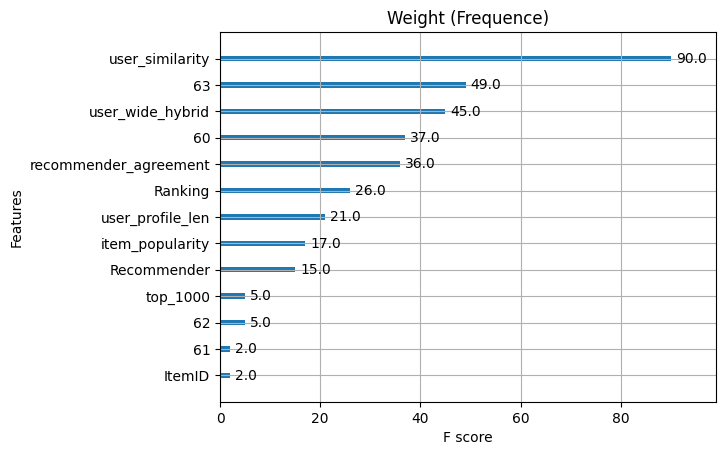

In [21]:
from xgboost import plot_importance

plot_importance(XGB_model, importance_type="weight", title="Weight (Frequence)")

### Model predictions

#### Decode predictions

In [21]:
y_val_hat = X_val[["UserID", "ItemID"]].copy()
y_val_hat["Score"] = XGB_model.predict(
    X_val,
)
y_val_hat

,UserID,ItemID,Score
256,0,454,-0.094380
257,0,8505,-0.068681
264,0,8505,-0.085446
265,0,14888,-0.064724
266,0,2746,-0.104188
...,...,...,...
17867978,35735,36775,0.012558
17867988,35735,37657,0.097238
17867989,35735,36493,0.088098
17867996,35735,36034,0.048838


In [22]:
val_items_dicts = (
    pl.from_pandas(y_val_hat[y_val]).group_by("UserID").agg(item_to_list()).to_dicts()
)
val_items_dicts[0]

{'UserID': 2379, 'ItemID': [[14748, 14748, 3638, 14748, 3638, 14748]]}

In [23]:
y_val_hat[y_val_hat["UserID"] == 35735].groupby("ItemID").aggregate({"Score": "mean"}).sort_values("Score", ascending=False)

,Score
ItemID,
37657,0.100747
36493,0.094613
37801,0.093326
36034,0.061902
37017,0.060956
37445,0.056658
36917,0.051948
36773,0.031359
36775,0.012558


In [24]:
val_predictions_dicts = (
    pl.from_pandas(y_val_hat)
    .group_by("UserID", "ItemID")
    .agg(pl.mean("Score"))
    .sort("UserID", "Score", descending=True)
    .group_by("UserID")
    .head(10)
    .group_by("UserID")
    .agg(item_to_list())
    .to_dicts()
)
val_predictions_dicts[0]

{'UserID': 35735,
 'ItemID': [[37657,
   36493,
   37801,
   36034,
   37017,
   37445,
   36917,
   36773,
   36775,
   37800]]}

In [25]:
val_predictions_dict = encode_user_dicts(val_predictions_dicts)
val_items_dict = encode_user_dicts(val_items_dicts)

In [26]:
len(val_items_dict.keys())

18314

In [27]:
len(val_predictions_dict.keys())

35736

#### Compute recommendation metrics

In [28]:
def map_at_k(predictions: dict[int, list], true_labels: dict[int, list], k=10):
    """
    Compute Mean Average Precision at K (MAP@K).

    Parameters:
    - predictions: A list of lists, where each inner list contains the predicted item IDs for a user (ranked in descending order of relevance).
    - true_labels: A list of sets, where each set contains the ground-truth relevant item IDs for the corresponding user.
    - k: The cutoff for precision evaluation.

    Returns:
    - mean_ap: Mean Average Precision at K across all users.
    """
    def average_precision_at_k(predicted, actual, k):
        if len(predicted) > k:
            predicted = predicted[:k]

        score = 0.0
        num_hits = 0.0

        for i, p in enumerate(predicted):
            if p in actual and p not in predicted[:i]:  # Avoid duplicates
                num_hits += 1.0
                score += num_hits / (i + 1.0)

        if not actual:
            return 0.0

        return score / min(len(actual), k)

    # Calculate AP@K for each user
    ap_scores = [
        average_precision_at_k(predictions[user], true, k)
        for user, true in true_labels.items()
    ]

    # Return the mean AP@K
    return np.mean(ap_scores) / len(ap_scores)


In [29]:
map_at_k(val_predictions_dict, val_items_dict)

5.558615161058339e-06

## Hyperparameter optimisation

How to perform hyperparameter tuning?

The issue with this method is that you need a label which should be an item the user has not interacted with but that is a correct recommendation. In practice the idea is:
- Split the data in the usual training-validation-test
- Split the training data in two: one part you use to train the recommenders and another you use as the hidden Label to train XGBoost
- Evaluate your predictions on the validation data as you did for any other recommender model. Use this to select the optimal hyperparameters.
- Given the selected hyperparameters, train the recommender models on all the available data and use all the available data to compute the features used by XGBoost.

Challenge: Since the label we use for training XGBoost is the split of a split, it may happen that the actual correct recommendations are very few. This will result in a problem that is very unbalanced towards zero and will make the training difficult and the evaluation noisy. To mitigate this you may use k-fold cross validation and define the valdation result of a certain hyperparameter configuration as the average obtained with k different training-label splits.

```python
import optuna
from sklearn.model_selection import KFold


def objective(trial):
    # Define the hyperparameter search space
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    reg_alpha = trial.suggest_float("reg_alpha", 0.0, 1.0)
    reg_lambda = trial.suggest_float("reg_lambda", 0.0, 1.0)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)

    # Initialize the XGBoost model
    model = XGBRanker(
        objective="rank:pairwise",
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
    )

    # Perform k-fold cross-validation
    kf = KFold(n_splits=5)
    scores = []

    for train_idx, val_idx in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        groups_train = groups[train_idx]
        groups_val = groups[val_idx]

        model.fit(
            X_train_fold, y_train_fold, group=groups_train, eval_metric="ndcg",
            eval_set=[(X_val_fold, y_val_fold)], verbose=False, early_stopping_rounds=10
        )
        predictions = model.predict(X_val_fold)
        score = map(predictions, y_val_fold)  # Replace with your metric
        scores.append(score)

    return sum(scores) / len(scores)  # Average score over k folds

# Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1)

# Get the best hyperparameters
best_params = study.best_params
print("Best parameters:", best_params)
```


## Submit

In [52]:
categorical_training_dataframe

,UserID,ItemID,Recommender,Ranking,recommender_agreement,23,21,22,20,user_wide_hybrid,item_popularity,item_similarity,user_profile_len,top_10,top_100,top_1000,user_similarity
0,0,6166,user_wide_hybrid,7,2,0.000000,0.142024,0.421410,0.353835,0.270525,129,0.000371,114,0.0,1.0,7.0,0.000183
1,0,11966,user_wide_hybrid,6,1,0.000000,0.145097,0.267107,0.893614,0.283992,52,0.000568,114,0.0,1.0,7.0,0.000183
2,0,2743,user_wide_hybrid,5,1,1.452733,0.195061,0.273309,0.521364,0.284803,39,0.000069,114,0.0,1.0,7.0,0.000183
3,0,2637,22,8,1,0.000000,0.197307,0.381694,0.790003,0.218590,67,0.000177,114,0.0,1.0,7.0,0.000183
4,0,738,22,9,1,1.694155,0.103107,0.370141,0.318969,0.093946,29,0.000474,114,0.0,1.0,7.0,0.000183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1786795,35735,36775,user_wide_hybrid,5,3,8.471791,0.328802,0.358924,2.157352,0.664134,88,0.003954,37,0.0,0.0,0.0,0.000272
1786796,35735,37445,user_wide_hybrid,4,5,7.411239,0.408742,0.455056,3.137702,0.680556,27,0.000132,37,0.0,0.0,0.0,0.000272
1786797,35735,36917,user_wide_hybrid,3,5,8.380329,0.453475,0.383239,2.259961,0.839466,76,0.004296,37,0.0,0.0,0.0,0.000272
1786798,35735,36034,user_wide_hybrid,2,5,10.576296,0.430645,0.403139,2.485576,1.015675,81,0.000403,37,0.0,0.0,0.0,0.000272


In [53]:
categorical_training_dataframe

,UserID,ItemID,Recommender,Ranking,recommender_agreement,23,21,22,20,user_wide_hybrid,item_popularity,item_similarity,user_profile_len,top_10,top_100,top_1000,user_similarity
0,0,6166,user_wide_hybrid,7,2,0.000000,0.142024,0.421410,0.353835,0.270525,129,0.000371,114,0.0,1.0,7.0,0.000183
1,0,11966,user_wide_hybrid,6,1,0.000000,0.145097,0.267107,0.893614,0.283992,52,0.000568,114,0.0,1.0,7.0,0.000183
2,0,2743,user_wide_hybrid,5,1,1.452733,0.195061,0.273309,0.521364,0.284803,39,0.000069,114,0.0,1.0,7.0,0.000183
3,0,2637,22,8,1,0.000000,0.197307,0.381694,0.790003,0.218590,67,0.000177,114,0.0,1.0,7.0,0.000183
4,0,738,22,9,1,1.694155,0.103107,0.370141,0.318969,0.093946,29,0.000474,114,0.0,1.0,7.0,0.000183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1786795,35735,36775,user_wide_hybrid,5,3,8.471791,0.328802,0.358924,2.157352,0.664134,88,0.003954,37,0.0,0.0,0.0,0.000272
1786796,35735,37445,user_wide_hybrid,4,5,7.411239,0.408742,0.455056,3.137702,0.680556,27,0.000132,37,0.0,0.0,0.0,0.000272
1786797,35735,36917,user_wide_hybrid,3,5,8.380329,0.453475,0.383239,2.259961,0.839466,76,0.004296,37,0.0,0.0,0.0,0.000272
1786798,35735,36034,user_wide_hybrid,2,5,10.576296,0.430645,0.403139,2.485576,1.015675,81,0.000403,37,0.0,0.0,0.0,0.000272


In [54]:
categorical_training_dataframe.drop(columns=["UserID", "ItemID"])

,Recommender,Ranking,recommender_agreement,23,21,22,20,user_wide_hybrid,item_popularity,item_similarity,user_profile_len,top_10,top_100,top_1000,user_similarity
0,user_wide_hybrid,7,2,0.000000,0.142024,0.421410,0.353835,0.270525,129,0.000371,114,0.0,1.0,7.0,0.000183
1,user_wide_hybrid,6,1,0.000000,0.145097,0.267107,0.893614,0.283992,52,0.000568,114,0.0,1.0,7.0,0.000183
2,user_wide_hybrid,5,1,1.452733,0.195061,0.273309,0.521364,0.284803,39,0.000069,114,0.0,1.0,7.0,0.000183
3,22,8,1,0.000000,0.197307,0.381694,0.790003,0.218590,67,0.000177,114,0.0,1.0,7.0,0.000183
4,22,9,1,1.694155,0.103107,0.370141,0.318969,0.093946,29,0.000474,114,0.0,1.0,7.0,0.000183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1786795,user_wide_hybrid,5,3,8.471791,0.328802,0.358924,2.157352,0.664134,88,0.003954,37,0.0,0.0,0.0,0.000272
1786796,user_wide_hybrid,4,5,7.411239,0.408742,0.455056,3.137702,0.680556,27,0.000132,37,0.0,0.0,0.0,0.000272
1786797,user_wide_hybrid,3,5,8.380329,0.453475,0.383239,2.259961,0.839466,76,0.004296,37,0.0,0.0,0.0,0.000272
1786798,user_wide_hybrid,2,5,10.576296,0.430645,0.403139,2.485576,1.015675,81,0.000403,37,0.0,0.0,0.0,0.000272


In [55]:
submission_prediction_dict = decode_predictions(categorical_training_dataframe, drop_ids=False)
submission_prediction_dict

{35735: [37657, 36493, 36773, 36917, 36034, 37445, 37660, 36920, 37865, 36775],
 35734: [37069, 36610, 36168, 35345, 37550, 37067, 35093, 36880, 37803, 36094],
 35733: [37853, 37388, 37372, 36056, 38072, 37540, 37858, 36676, 28418, 28304],
 35732: [27590, 37317, 27644, 31350, 38005, 33330, 37402, 27814, 37109, 36919],
 35731: [37739, 36263, 38027, 37427, 36525, 37623, 28119, 35394, 36856, 27349],
 35730: [28247, 38027, 37211, 37420, 37739, 37874, 27350, 28119, 37719, 37631],
 35729: [36844, 26093, 24415, 24417, 35548, 36527, 26581, 27531, 37461, 27067],
 35728: [35370, 35777, 36665, 14090, 19651, 28374, 37565, 27497, 27510, 36346],
 35727: [37280, 27520, 28088, 28203, 37416, 37291, 37712, 28097, 14664, 27693],
 35726: [37851, 37940, 37527, 28447, 27768, 37740, 28234, 36866, 38045, 37510],
 35725: [36652, 37540, 28458, 37431, 37661, 37785, 38018, 28547, 37924, 27623],
 35724: [28281, 37178, 37940, 36866, 27346, 36504, 26869, 27689, 27756, 37461],
 35723: [28461, 28247, 36065, 37739, 365

In [56]:
def encode_recommendation(recommendation: list[str]) -> str:
    return " ".join([str(item) for item in recommendation])

In [57]:
test_df["item_list"] = [
    encode_recommendation(recommendation)
    for recommendation in pd.Series(submission_prediction_dict).loc[test_df["user_id"]]
]
test_df

,user_id,item_list
0,0,572 7547 9911 399 7703 11580 14888 531 4232 28958
1,1,6348 14748 13766 9812 18964 11149 7139 572 313...
2,2,8403 22692 15542 29963 13252 22714 21363 22589...
3,3,25140 25079 6189 25643 23023 23712 11362 6827 ...
4,4,15902 9812 17624 8612 9447 18304 4695 18647 34...
...,...,...
34226,35729,36844 26093 24415 24417 35548 36527 26581 2753...
34227,35730,28247 38027 37211 37420 37739 37874 27350 2811...
34228,35731,37739 36263 38027 37427 36525 37623 28119 3539...
34229,35734,37069 36610 36168 35345 37550 37067 35093 3688...


In [58]:
test_df.to_csv(SUBMISSION_PATH, index=False)